In [1]:
import sys
sys.path.append('../')

# Visualize the regression result


In [34]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive
import cartopy.crs as ccrs
%config InlineBackend.figure_format='retina'

In [35]:
from main import setup_dataset, setup_model, setup_criterion, adjust_model, ArgumentParser
from niwa.climate import Climate
from niwa.climate_obs import ClimateObservational
import niwa.climate

## Read checkpoint file

In [4]:
cpfile = '../model.pth'
# cpfile = '../model-b0-sgd.pth'
# cpfile = '../model-dm-1em4-b0-sgd.pth'
# cpfile = '../model-vcsn_grad-b7-adam.pth'
# cpfile = '../model-dm-1em4-b0-sgd-1.pth'
# cpfile = '../model-grad2d-1em2-b0-sgd.pth'
# cpfile = '../model-vcsn_grad-b0-sgd.pth'
# cpfile = '../model-vcsn_grad-b7-sgd.pth'
# cpfile = '../experiments/20201112-sst_rain/sst_rain_run1.pth'

cp = torch.load(cpfile)

## Setup Arguments

In [5]:
def default_args():
    args = ArgumentParser().parse_args(args=[])

    args.batch_size = 10
    args.regression_vcsn = True
    args.disable_data_parallel = True
    args.arch = 'efficientnet-b0'
    args.gcm_root = '/Scratch/dh146/ECMWF/'
    args.vcsn_root = '/Scratch/dh146/VCSN'
    args.climate_standardization = False
    args.vcsn_grad = False
    
    return args

if 'args' in cp and type(cp['args']) is dict:
    args = ArgumentParser().from_dict(cp['args'])
    print('Loaded arguments in the checkpoint.')
    print(args)
else:
    print('No arguments in the saved checkpoint. Using default arguments.')
    args = default_args()

Loaded arguments in the checkpoint.
{'arch': 'efficientnet-b0',
 'batch_size': 40,
 'betas': (0.9, 0.999),
 'climate_standardization': True,
 'data_class': <class 'niwa.climate_obs.ClimateObservational'>,
 'disable_data_parallel': False,
 'dtype': torch.float32,
 'epochs': 120,
 'gcm_3ms': False,
 'gcm_root': '/Scratch/dh146/ECMWF',
 'gpu': None,
 'hash': '-1d8bb73f9f178a5b',
 'image_size': 224,
 'lr': 0.1,
 'lr_interval': 40,
 'momentum': 0.9,
 'n_classes': 3,
 'n_input_chan': 6,
 'niwa_climate': 'RAIN',
 'niwa_gcm': 'JMA',
 'niwa_region': 'NNI',
 'no_tensorboard': False,
 'optim': 'sgd',
 'regression_scalar': '',
 'regression_scalar_list': [],
 'regression_vcsn': True,
 'save_checkpoint': True,
 'smooth_lambda': 1e-15,
 'smooth_type': 'grad2d',
 'sst_rain': True,
 'start_epoch': 0,
 'stratified': False,
 'tb_prefix': '',
 'tb_tag': '',
 'vcsn_grad': False,
 'vcsn_root': '/Scratch/dh146/VCSN',
 'weight_decay': 0.0001,
 'workers': 4}


In [6]:
# However, we always disable DataParallel model in evaluating the result.
args.disable_data_parallel = True

## Decide the climatology variable

In [7]:
CLIMATO_VAR = 'rain' if args.sst_rain else 'temp'

## Setup model and dataset



In [8]:
train_loader, test_loader = setup_dataset(args)
model = setup_model(args)
adjust_model(model, args)

Using image size 224
<xarray.Dataset>
Dimensions:         (lat: 257, lon: 241, time: 490)
Coordinates:
  * lon             (lon) float32 166.475 166.525 166.575 ... 178.425 178.475
  * lat             (lat) float32 -47.275 -47.225 -47.175 ... -34.475 -34.425
  * time            (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month           (time) int64 dask.array<chunksize=(490,), meta=np.ndarray>
Data variables:
    Rain_bc         (time, lat, lon) float32 dask.array<chunksize=(490, 257, 241), meta=np.ndarray>
    agent           (time, lat, lon) float32 dask.array<chunksize=(490, 257, 241), meta=np.ndarray>
    mask            (lat, lon) float64 dask.array<chunksize=(257, 241), meta=np.ndarray>
    Rain_bc_interp  (time, lat, lon) float64 dask.array<chunksize=(490, 257, 241), meta=np.ndarray>
GCM and VCSN databases processed.
<xarray.Dataset>
Dimensions:         (lat: 257, lon: 241, time: 490)
Coordinates:
  * lon             (lon) float32 166.475 166.525 166.575 ... 

In [38]:
criterion = setup_criterion(args).cpu()
mse_criterion = nn.MSELoss()

## Load parameters from checkpoint

In [9]:
model.load_state_dict(cp['state_dict'])


<All keys matched successfully>

## Read the mask from VCSN

In [10]:
def vcsn_file(variable):
    return f'{args.vcsn_root}/{variable}/seasonal_anomalies_VCSN_{variable}_N.nc'
ds_vcsn_tmean = xr.open_dataset(vcsn_file('TMEAN'))
ds_vcsn_tmean

<xarray.Dataset>
Dimensions:         (lat: 257, lon: 241, time: 490)
Coordinates:
  * lat             (lat) float32 -47.275 -47.225 -47.175 ... -34.475 -34.425
  * lon             (lon) float32 166.475 166.525 166.575 ... 178.425 178.475
  * time            (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month           (time) int64 ...
Data variables:
    agent           (time, lat, lon) float32 ...
    Tmean_N         (time, lat, lon) float32 ...
    Tmean_N_interp  (time, lat, lon) float64 ...
    mask            (lat, lon) float64 ...

## Compute the output

In [60]:
def month_of_sample(index, split='test', base_offset=0):
    from niwa.climate import TIME_FIRST_TRAIN, TIME_LAST_TRAIN, TIME_FIRST_TEST, TIME_LAST_TEST
    first = TIME_FIRST_TEST if split == 'test' else TIME_FIRST_TRAIN
    last = TIME_LAST_TEST if split == 'test' else TIME_LAST_TRAIN
    if index >= 0:
        return first + (index + base_offset) * np.timedelta64(1, 'M')
    else:
        return last + (index + 1 + base_offset) * np.timedelta64(1, 'M')


def draw_output(index, split='test', results=None, variable='temp', savefig=None, month_offset=0,
               vmin=-2, vmax=2, n_channels=3):
    global output_last, image_last
    test_sample_index = index

#     from niwa.climate import TIME_FIRST_TEST, TIME_LAST_TEST
#     if test_sample_index >= 0:
#         date_label = TIME_FIRST_TEST + test_sample_index * np.timedelta64(1, 'M')
#     else:
#         date_label = TIME_LAST_TEST + (test_sample_index + 1) * np.timedelta64(1, 'M')

    date_label = month_of_sample(index, split, base_offset=month_offset).astype(str)
    
    if results is not None:
        output, target, image = results[test_sample_index]
    else:
        loader = train_loader if split == 'train' else test_loader
        image, target = loader.dataset[test_sample_index]
        image_last = image.clone()

        model.eval()
        with torch.no_grad():
            output = model.cpu()(image.unsqueeze(dim=0)).squeeze(dim=0)
        
    mse = mse_criterion(output, target).item()
    
    cmap = plt.cm.get_cmap("RdBu_r", 31)

    K = 11_491

    boolean_mask = ~np.isnan(ds_vcsn_tmean.mask).data

    img_output = np.empty(boolean_mask.shape)
    img_output[:] = np.nan
    output_np = output.numpy()
    img_output[boolean_mask] = output_np[:K]

    img_gt = np.empty(boolean_mask.shape)
    img_gt[:] = np.nan
    img_gt[boolean_mask] = target[:K]

    is_six_channels = n_channels == 6
    nrows = 3 if is_six_channels else 1
    figsize = (14, 12) if is_six_channels else (14, 4)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=figsize, ncols=3, dpi=192, nrows=nrows)
    if nrows > 1:
        axes_row2 = ax2
        axes_row3 = ax3
        ax1, ax2, ax3 = ax1

    p1 = ax1.pcolor(img_output, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(p1, ax=ax1)
    ax1.set_title(f'{date_label}: Regression')
    ax1.text(5, 200, f'MSE={mse:.4g}')


    p2 = ax2.pcolor(img_gt, cmap=cmap, vmin=vmin, vmax=vmax)
    ax2.set_title(f'{date_label}: Ground Truth')
    # ax.title(f'{date_label}: Ground Truth')
    fig.colorbar(p2, ax=ax2)
    
    if variable == 'temp':
        image = F.interpolate(image.unsqueeze(dim=0), size=180, mode='bilinear')
        image = image.squeeze(dim=0).transpose(0, 2) # transpose the dim0 (time) and dim2 (lon)
        image = torch.clamp((image + 3) / 6, 0, 1)
        p3 = ax3.imshow(image)
        ax3.set_title(f'{date_label}: ECMWF')
    else:
#         image = torch.clamp((image + 3) / 6, 0, 1)
            
        if not is_six_channels:
            p3 = ax3.pcolormesh(image[0, ...], cmap=cmap, vmin=-3, vmax=3)
            ax3.set_title(f'{date_label}: Input (-3M, -2M, -1M, SST)')
            fig.colorbar(p3, ax=ax3)

        else:
            p3 = ax3.pcolormesh(np.zeros(image[0, ...].shape), cmap=cmap, vmin=-3, vmax=3)
            ax3.set_title(f'Blank')
            fig.colorbar(p3, ax=ax3)
            
            for i, ax in enumerate(axes_row2):
                p = ax.pcolormesh(image[i, ...], cmap=cmap, vmin=-3, vmax=3)
                ax.set_title(f'{date_label}: -{3-i} month')
                fig.colorbar(p, ax=ax)

            for i, ax in enumerate(axes_row3):
                p = ax.pcolormesh(image[i+3, ...], cmap=cmap, vmin=-3, vmax=3)
                ax.set_title(f'{date_label}: -{3-i} month')
                fig.colorbar(p, ax=ax)
    
#     plt.title('Regression result on test set\n'
#           'Variable: Rain_bc (VCSN), sst (ERSST)\n'
#           'Input: sst in current month, Rain_bc in -3, -2, -1 month\n'
#           'Target: Rain_bc in current month')
    if savefig is not None:
        plt.savefig(savefig)
        plt.close()
    else:
        plt.show()
    print(f'Out: {np.nanmean(img_output):.2f}, {np.nanstd(img_output):.2f}, '
          f'GT: {np.nanmean(img_gt):.2f}, {np.nanstd(img_gt):.2f}, '
          f'Input: {image.mean():.2f}, {image.std():.2f}')


In [61]:
model.eval()
with torch.no_grad():
    test_results = [(model(image.unsqueeze(dim=0).cuda()).cpu(), target, image)
                   for image, target in test_loader.dataset]
outputs = torch.cat([r[0] for r in test_results], dim=0)
targets = torch.stack([r[1] for r in test_results], dim=0)
images = torch.stack([r[2] for r in test_results], dim=0)
test_results = list(zip(outputs, targets, images))
test_outputs = outputs
test_targets = targets

variable = 'rain' if args.sst_rain else 'temp'
month_offset = 3 if args.sst_rain else 0

vmax_rain = 3 if args.sst_rain and args.climate_standardization else 600

vmin = {'temp': -2, 'rain': -vmax_rain}[variable]
vmax = {'temp': 2, 'rain': vmax_rain}[variable]

In [62]:
interactive(lambda index: draw_output(index, results=test_results,
                                      variable=variable, month_offset=month_offset,
                                     vmax=vmax, vmin=vmin, n_channels=args.n_input_chan),
            index=(0, len(test_results)-1))

interactive(children=(IntSlider(value=10, description='index', max=20), Output()), _dom_classes=('widget-inter…

In [65]:
# for i in range(len(test_results)):
#     draw_output(i, results=test_results, variable=variable, month_offset=month_offset,
#                 vmax=vmax, vmin=vmin, n_channels=args.n_input_chan,
#                 savefig=f'../extras/experiment-sst-vcsn-rain-6chans-testset-Dec2/images/test_{i:03}.jpg')

Out: -0.13, 0.16, GT: -0.00, 0.61, Input: -0.24, 0.87
Out: 0.67, 0.89, GT: 0.36, 0.89, Input: -0.20, 0.87
Out: 0.59, 0.94, GT: 0.83, 1.57, Input: -0.11, 0.86
Out: 0.47, 0.66, GT: 0.31, 1.29, Input: 0.03, 1.00
Out: 0.02, 0.05, GT: 0.17, 1.05, Input: 0.07, 1.10
Out: 0.01, 0.29, GT: -0.33, 0.82, Input: 0.08, 1.14
Out: 0.13, 0.35, GT: -0.37, 0.76, Input: 0.03, 1.02
Out: 0.07, 0.29, GT: -0.49, 0.80, Input: 0.00, 0.98
Out: 0.04, 0.47, GT: -0.77, 0.74, Input: -0.03, 0.97
Out: 0.10, 0.64, GT: -0.32, 0.44, Input: -0.05, 0.99
Out: 0.25, 0.54, GT: -0.01, 0.71, Input: -0.06, 0.96
Out: 0.19, 0.75, GT: 0.43, 1.26, Input: -0.03, 0.94
Out: 0.41, 0.81, GT: -0.09, 1.13, Input: 0.04, 0.99
Out: 0.17, 0.68, GT: 0.41, 1.20, Input: 0.05, 1.04
Out: 0.43, 0.47, GT: 0.38, 1.07, Input: 0.07, 1.09
Out: 0.17, 0.49, GT: 0.91, 1.57, Input: 0.07, 1.04
Out: 0.15, 0.46, GT: -0.12, 0.61, Input: 0.14, 1.15
Out: 0.04, 0.08, GT: -0.23, 0.86, Input: 0.12, 1.07
Out: -0.14, 0.44, GT: -0.56, 1.29, Input: 0.10, 1.05
Out: -0.10,

In [32]:
model.eval()
with torch.no_grad():
    train_results = [(model(image.unsqueeze(dim=0).cuda()).cpu(), target, image)
                   for image, target in train_loader.dataset]
outputs = torch.cat([r[0] for r in train_results], dim=0)
targets = torch.stack([r[1] for r in train_results], dim=0)
images = torch.stack([r[2] for r in train_results], dim=0)
train_results = list(zip(outputs, targets, images))
train_outputs = outputs
train_targets = targets

vmax_rain = 3 if args.sst_rain and args.climate_standardization else 600

vmin = {'temp': -2, 'rain': -vmax_rain}[variable]
vmax = {'temp': 2, 'rain': vmax_rain}[variable]

# model.eval()
# with torch.no_grad():
#     train_results = [(model(image.cuda()).cpu(), target) for image, target in train_loader]
# outputs = torch.cat([r[0] for r in train_results], dim=0)
# targets = torch.cat([r[1] for r in train_results], dim=0)
# train_results = list(zip(outputs, targets))

In [63]:
interactive(lambda index: draw_output(index, results=train_results, split='train', variable=variable,
                                     vmax=vmax, vmin=vmin, n_channels=args.n_input_chan),
            index=(0, len(train_results)-1))

interactive(children=(IntSlider(value=128, description='index', max=257), Output()), _dom_classes=('widget-int…

In [66]:
# for i in range(10, 20):
#     draw_output(i, results=test_results)
for i in range(len(train_results)):
    draw_output(i, results=train_results, split='train', variable=variable, month_offset=month_offset,
                vmax=vmax, vmin=vmin, n_channels=args.n_input_chan,
                savefig=f'../extras/experiment-sst-vcsn-rain-6chans-trainset-Dec2/images/test_{i:03}.jpg')

Out: 0.46, 1.07, GT: -0.01, 1.21, Input: -0.12, 0.85
Out: 0.02, 0.83, GT: -0.47, 0.97, Input: -0.09, 0.93
Out: -0.77, 0.77, GT: -1.19, 1.01, Input: -0.11, 1.00
Out: -0.48, 0.47, GT: -0.74, 0.77, Input: -0.24, 1.13
Out: -0.30, 0.41, GT: -0.49, 0.75, Input: -0.31, 1.09
Out: -0.17, 0.31, GT: -0.29, 0.84, Input: -0.32, 1.04
Out: 0.35, 0.36, GT: 0.32, 0.76, Input: -0.26, 0.89
Out: 0.36, 0.50, GT: 0.29, 0.90, Input: -0.18, 0.85
Out: 0.38, 0.54, GT: 0.22, 0.93, Input: -0.13, 0.87
Out: -0.16, 0.30, GT: -0.34, 0.78, Input: -0.10, 0.87
Out: 0.22, 0.33, GT: 0.10, 0.56, Input: -0.13, 0.86
Out: 0.48, 0.64, GT: 0.30, 0.69, Input: -0.13, 0.79
Out: 0.72, 0.90, GT: 0.74, 0.83, Input: -0.11, 0.76
Out: 0.67, 0.91, GT: 0.58, 0.80, Input: -0.02, 0.83
Out: 0.65, 0.82, GT: 0.65, 0.70, Input: 0.01, 0.92
Out: 0.11, 0.17, GT: -0.09, 0.57, Input: 0.02, 0.97
Out: 0.81, 1.03, GT: 0.71, 1.05, Input: -0.04, 0.89
Out: 0.31, 0.53, GT: -0.04, 0.66, Input: -0.02, 0.95
Out: 0.63, 1.00, GT: 0.27, 1.15, Input: -0.05, 0.89


In [17]:
# for i in range(-1, -10, -1):
#     draw_output(i, split='train')

## Regional aggregation

In [18]:
nz_6_regions = ('ENI', 'ESI', 'NNI', 'NSI', 'WNI', 'WSI')

In [19]:
climato_tmean = xr.open_dataset('../dataset/climatology_average_Q33_Q66_Tmean.nc')
climato_tmean

<xarray.Dataset>
Dimensions:        (lat: 257, lon: 241, month: 12)
Coordinates:
  * lon            (lon) float64 166.5 166.5 166.6 166.6 ... 178.4 178.4 178.5
  * lat            (lat) float64 -47.27 -47.23 -47.17 ... -34.52 -34.48 -34.42
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Tmean_average  (month, lat, lon) float64 ...
    Tmean_Q33      (month, lat, lon) float64 ...
    Tmean_Q66      (month, lat, lon) float64 ...

In [20]:
climato_rain = xr.open_dataset('../dataset/climatology_average_Q33_Q66_Rain_bc.nc')
climato_rain

<xarray.Dataset>
Dimensions:          (lat: 257, lon: 241, month: 12)
Coordinates:
  * lon              (lon) float64 166.5 166.5 166.6 166.6 ... 178.4 178.4 178.5
  * lat              (lat) float64 -47.27 -47.23 -47.17 ... -34.52 -34.48 -34.42
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Rain_bc_average  (month, lat, lon) float64 ...
    Rain_bc_Q33      (month, lat, lon) float64 ...
    Rain_bc_Q66      (month, lat, lon) float64 ...

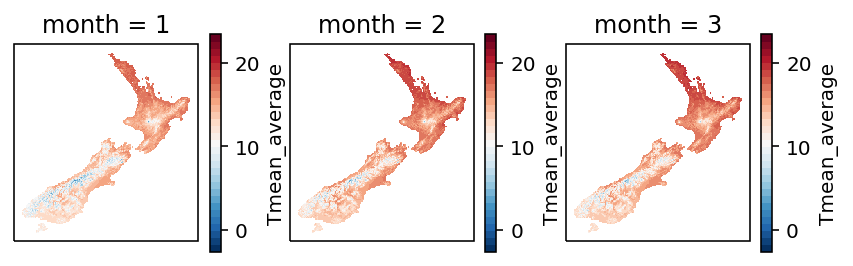

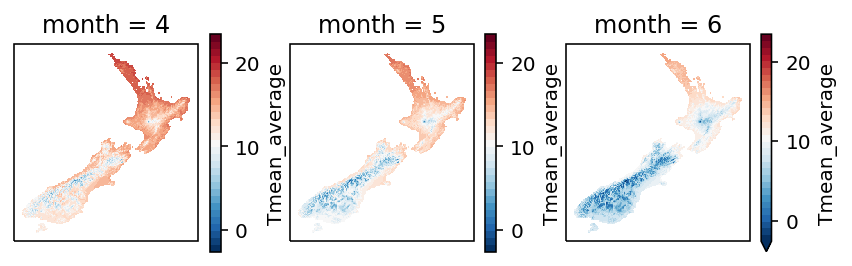

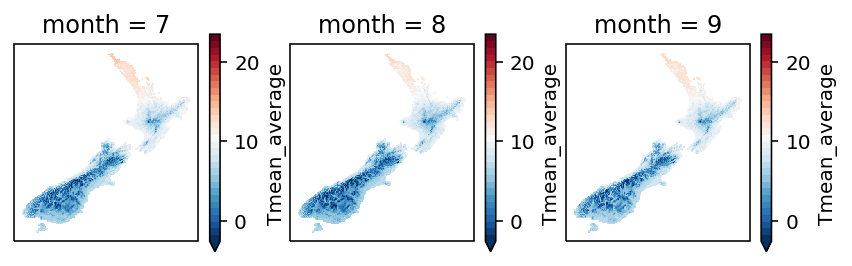

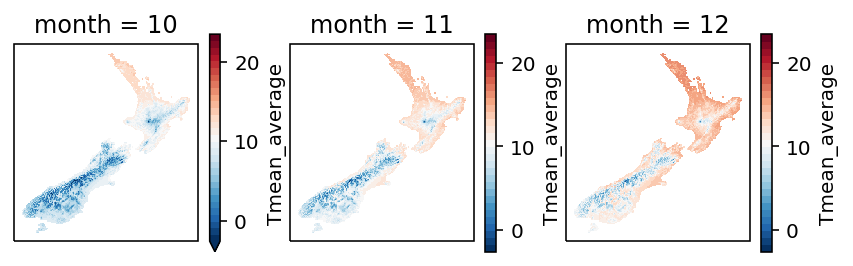

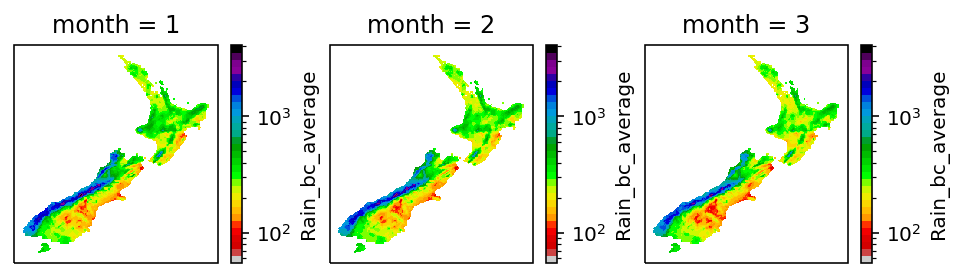

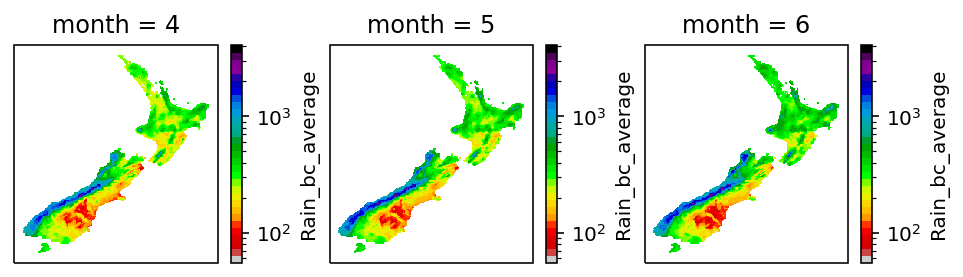

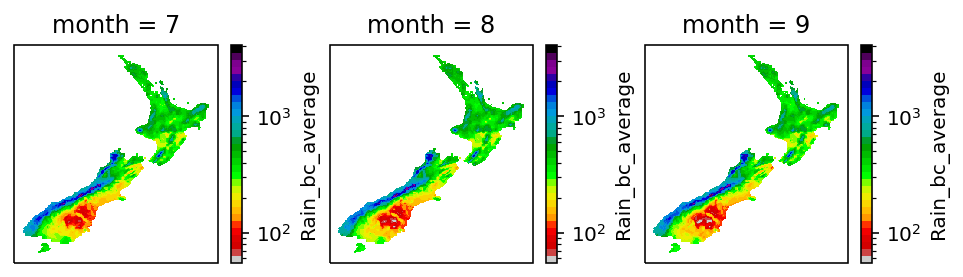

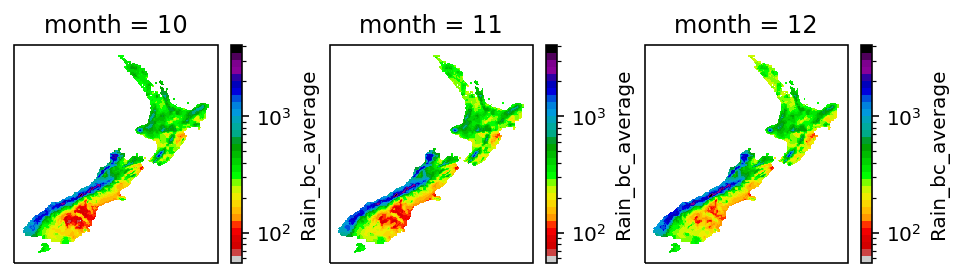

In [49]:
temp_median = climato_tmean.Tmean_average.median()
temp_std = climato_tmean.Tmean_average.std()

rain_min = climato_rain.Rain_bc_average.min()
rain_max = climato_rain.Rain_bc_average.max()

vmin_dict = {'temp': temp_median-3*temp_std, 'rain': rain_min}
vmax_dict = {'temp': temp_median+3*temp_std, 'rain': rain_max}
for i in range(4):
    vmin, vmax = vmin_dict['temp'], vmax_dict['temp']
    cmap = plt.cm.get_cmap("RdBu_r", 31)

    fig, axes = plt.subplots(1, 3, figsize=(7, 2), subplot_kw={'projection': ccrs.PlateCarree()})
    for j in range(3):
        climato_tmean.Tmean_average[i*3 + j].plot(
            ax=axes[j], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
    plt.savefig(f'../extras/vcsn-climatology-Nov17/images/temp-{i*3+1:02}-{i*3+3:02}.jpg')
    plt.show()

for i in range(4):
    vmin, vmax = vmin_dict['rain'], vmax_dict['rain']
    cmap = plt.cm.get_cmap("nipy_spectral_r", 31)

    fig, axes = plt.subplots(1, 3, figsize=(8, 2), subplot_kw={'projection': ccrs.PlateCarree()})
    for j in range(3):
        climato_rain.Rain_bc_average[i*3 + j].plot(
            ax=axes[j], transform=ccrs.PlateCarree(),
            norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap)
    plt.savefig(f'../extras/vcsn-climatology-Nov17/images/rain-{i*3+1:02}-{i*3+3:02}.jpg')
    plt.show()


In [43]:
if CLIMATO_VAR == 'rain':
    target_var_average = climato_rain.Rain_bc_average
else:
    target_var_average = climato_tmean.Tmean_average
    
def _plot(index):
    vmin = target_var_average.min()
    vmax = target_var_average.max()
#     target_var_average[index].plot(vmin=vmin, vmax=vmax, cmap='rainbow')
    target_var_average[index].plot(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='nipy_spectral_r')
    plt.show()
interactive(_plot, index=(0, len(target_var_average) - 1))

interactive(children=(IntSlider(value=5, description='index', max=11), Output()), _dom_classes=('widget-intera…

In [44]:
ds_regional_masks = xr.open_dataset('../dataset/NZ_6_regions_mask.nc')
ds_regional_masks

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241)
Coordinates:
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    region   (lat, lon) float64 ...
    NNI      (lat, lon) float64 ...
    WNI      (lat, lon) float64 ...
    ENI      (lat, lon) float64 ...
    NSI      (lat, lon) float64 ...
    WSI      (lat, lon) float64 ...
    ESI      (lat, lon) float64 ...

In [20]:
ds_regional_masks.NSI.data[~np.isnan(ds_regional_masks.NSI)]

array([1., 1., 1., ..., 1., 1., 1.])

In [45]:
thresholds_temp = pd.read_csv('../dataset/Climatological_quantiles_3_cat_TMEAN.csv',
                        header=2, index_col=0)
# Tuple of regions below must be hard coded here explicitly to match the order in CSV file.
thresholds_temp.columns = [f'{region}_{split}' for region in ('NNI', 'ENI', 'WNI', 'NSI', 'WSI', 'ESI')
                      for split in ('Q33', 'Q66')]
thresholds_temp

NNI_Q33    NNI_Q66    ENI_Q33    ENI_Q66    WNI_Q33    WNI_Q66  \
season                                                                     
1       16.192205  16.711533  14.558706  15.362723  14.022534  14.757577   
2       17.571612  18.161279  15.981903  16.667819  15.606067  16.212981   
3       17.602604  18.059826  15.896412  16.301075  15.457978  15.979070   
4       16.337604  16.868952  14.347398  14.918828  13.997594  14.607034   
5       14.278205  14.800033  12.146405  12.752033  11.807512  12.544035   
6       11.937089  12.446445   9.975187  10.346840   9.660703  10.105945   
7       10.140742  10.559623   8.026645   8.555372   7.794877   8.388257   
8        9.344997   9.853737   7.247226   7.791770   7.057408   7.653609   
9        9.839720  10.300074   7.922671   8.322755   7.723394   8.141653   
10      11.094165  11.481375   9.244114   9.713870   8.924829   9.452946   
11      12.674836  13.070894  10.943933  11.396907  10.612022  11.094864   
12      14.446111  14.946266  12.860775  13.555343  12.316661  13.091015   

          NSI_Q33    NSI_Q66    WSI_Q33    WSI_Q66    ESI_Q33    ESI_Q66  
season                                                                    
1       12.448537  12.884851  11.025878  11.590436  12.590779  13.460794  
2       13.717394  14.390106  12.308727  12.847326  13.961950  14.570645  
3       13.651205  14.092328  12.135498  12.709280  13.676743  14.276748  
4       12.342522  12.731987  10.541552  11.236765  11.905881  12.646973  
5        9.936486  10.498057   8.150917   8.723350   9.445587  10.051895  
6        7.485466   7.804372   5.610571   6.098422   6.795469   7.332978  
7        5.281846   5.965562   3.441573   3.955721   4.597933   5.222299  
8        4.505057   5.402480   2.709681   3.470722   3.970116   4.473995  
9        5.378278   5.961090   3.693716   4.301107   5.058928   5.548815  
10       6.941567   7.318055   5.593627   5.853764   6.972609   7.469444  
11       8.624462   9.047063   7.385151   7.846476   8.933834   9.485311  
12      10.495509  11.052956   9.198244   9.840042  10.838836  11.383775

In [46]:
thresholds_rain = pd.read_csv('../dataset/Climatological_quantiles_3_cat_RAIN.csv',
                        header=2, index_col=0)
# Tuple of regions below must be hard coded here explicitly to match the order in CSV file.
thresholds_rain.columns = [f'{region}_{split}' for region in ('NNI', 'ENI', 'WNI', 'NSI', 'WSI', 'ESI')
                      for split in ('Q33', 'Q66')]
thresholds_rain

NNI_Q33     NNI_Q66     ENI_Q33     ENI_Q66     WNI_Q33  \
season                                                               
1       288.359455  334.235363  281.589270  326.112212  348.916600   
2       250.097409  335.675000  249.600106  301.837312  296.581908   
3       260.512343  333.511089  254.812169  321.354540  256.665974   
4       282.961238  360.999076  264.030582  348.579344  266.287317   
5       312.963498  386.398614  295.950984  376.681608  320.820037   
6       397.443795  461.811452  329.051831  422.451429  390.921450   
7       431.702195  524.193746  387.451937  465.913354  429.801998   
8       446.760776  545.369307  397.700296  503.327386  426.384812   
9       423.607277  515.329851  382.960593  458.967513  420.090754   
10      370.190957  447.424901  326.405460  391.074413  431.839249   
11      324.326832  394.091848  312.060402  351.099132  390.115348   
12      313.372013  392.597228  284.983894  351.415598  407.082254   

           WNI_Q66     NSI_Q33     NSI_Q66     WSI_Q33     WSI_Q66  \
season                                                               
1       398.738902  479.914657  580.750971  657.921417  818.005332   
2       362.486198  430.457424  501.747252  623.339728  747.698992   
3       332.468558  384.623571  477.170550  561.146222  681.690654   
4       329.403784  389.914028  488.675964  562.131662  633.773288   
5       364.718385  419.313071  542.254662  604.171299  722.096149   
6       449.137943  514.021274  600.028001  591.580082  709.378474   
7       506.241274  512.530763  629.582089  592.513170  692.534641   
8       536.398135  542.166694  634.106344  570.200118  653.450263   
9       510.905329  510.189636  679.727153  567.493896  680.751371   
10      505.604050  582.812688  688.436642  623.459373  741.914133   
11      467.826832  557.985179  672.269374  626.509246  777.865640   
12      455.129843  563.799453  684.261034  684.300936  829.413551   

           ESI_Q33     ESI_Q66  
season                          
1       161.024717  189.796383  
2       154.230767  185.233517  
3       145.086833  176.136633  
4       146.027717  180.986433  
5       147.856350  186.082967  
6       143.733483  175.711917  
7       145.775500  186.787650  
8       146.918300  184.483767  
9       134.860083  183.771150  
10      141.244150  183.608383  
11      160.506833  185.879933  
12      166.360550  209.537167

### Sanity check using the csv file

In [22]:
precomputed_file = '/downscaling/CSV/TEST/GCMs_and_targets_cat3_and_anomalies_TMEAN_test_set.csv'

In [23]:
df_precomp = pd.read_csv(precomputed_file)
df_precomp = df_precomp.iloc[:, [0, *range(-6, 0)]].drop_duplicates().sort_values(by=[df_precomp.columns[0]])
df_precomp

Unnamed: 0  NNI_cat3_categories  WNI_cat3_categories  ENI_cat3_categories  \
0   2017-04-30                  3.0                  3.0                  3.0   
1   2017-05-31                  3.0                  3.0                  3.0   
2   2017-06-30                  3.0                  2.0                  2.0   
3   2017-07-31                  2.0                  2.0                  2.0   
4   2017-08-31                  3.0                  3.0                  3.0   
5   2017-09-30                  3.0                  3.0                  3.0   
6   2017-10-31                  3.0                  3.0                  3.0   
7   2017-11-30                  3.0                  3.0                  3.0   
8   2017-12-31                  3.0                  3.0                  3.0   
9   2018-01-31                  3.0                  3.0                  3.0   
10  2018-02-28                  3.0                  3.0                  3.0   
11  2018-03-31                  3.0                  3.0                  3.0   
12  2018-04-30                  3.0                  3.0                  3.0   
13  2018-05-31                  3.0                  3.0                  3.0   
14  2018-06-30                  3.0                  2.0                  3.0   
15  2018-07-31                  3.0                  2.0                  3.0   
16  2018-08-31                  3.0                  2.0                  3.0   
17  2018-09-30                  3.0                  3.0                  3.0   
18  2018-10-31                  2.0                  2.0                  3.0   
19  2018-11-30                  2.0                  2.0                  2.0   
20  2018-12-31                  3.0                  3.0                  2.0   
21  2019-01-31                  3.0                  3.0                  3.0   
22  2019-02-28                  3.0                  3.0                  3.0   
23  2019-03-31                  3.0                  3.0                  3.0   
24  2019-04-30                  3.0                  3.0                  3.0   
25  2019-05-31                  3.0                  3.0                  3.0   
26  2019-06-30                  2.0                  3.0                  2.0   
27  2019-07-31                  3.0                  3.0                  3.0   
28  2019-08-31                  3.0                  3.0                  3.0   
29  2019-09-30                  3.0                  3.0                  3.0   
30  2019-10-31                  3.0                  2.0                  2.0   
31  2019-11-30                  3.0                  3.0                  3.0   
32  2019-12-31                  3.0                  3.0                  3.0   

    NSI_cat3_categories  WSI_cat3_categories  ESI_cat3_categories  
0                   2.0                  2.0                  2.0  
1                   2.0                  2.0                  2.0  
2                   2.0                  2.0                  2.0  
3                   2.0                  2.0                  1.0  
4                   2.0                  3.0                  3.0  
5                   2.0                  3.0                  3.0  
6                   3.0                  3.0                  3.0  
7                   3.0                  3.0                  3.0  
8                   3.0                  3.0                  3.0  
9                   3.0                  3.0                  3.0  
10                  3.0                  3.0                  3.0  
11                  3.0                  3.0                  3.0  
12                  2.0                  2.0                  2.0  
13                  2.0                  1.0                  2.0  
14                  2.0                  1.0                  1.0  
15                  2.0                  2.0                  2.0  
16                  3.0                  3.0                  3.0  
17                  3.0  

In [24]:
vcsn_ano_file = '/Scratch/dh146/VCSN/TMEAN/seasonal_anomalies_VCSN_TMEAN_N.nc'
ds_vcsn_anomaly = xr.open_dataset(vcsn_ano_file)
ds_vcsn_anomaly

<xarray.Dataset>
Dimensions:         (lat: 257, lon: 241, time: 490)
Coordinates:
  * lat             (lat) float32 -47.275 -47.225 -47.175 ... -34.475 -34.425
  * lon             (lon) float32 166.475 166.525 166.575 ... 178.425 178.475
  * time            (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month           (time) int64 ...
Data variables:
    agent           (time, lat, lon) float32 ...
    Tmean_N         (time, lat, lon) float32 ...
    Tmean_N_interp  (time, lat, lon) float64 ...
    mask            (lat, lon) float64 ...

In [25]:
vcsn_raw_file = '/downscaling/VCSN/ORIG/MONTHLY/TMEAN_N/VCSN_gridded_Tmean_N_1979-01_2019-12.nc'
ds_vcsn_raw = xr.open_dataset(vcsn_raw_file)
ds_vcsn_raw

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Data variables:
    agent    (lat, lon) float32 ...
    Tmean_N  (time, lat, lon) float64 ...

In [26]:
ds_vcsn_raw.time[0].data.astype('datetime64[M]')

array('1979-01', dtype='datetime64[M]')

In [27]:
date = ds_vcsn_raw.time[0].data.astype('datetime64[M]')
vcsn_raw_cat3 = {r: [] for r in nz_6_regions}
for i, temperature in enumerate(ds_vcsn_raw.Tmean_N.data):
    month = pd.DatetimeIndex([date]).month[0]
    month_b0 = month - 1
    q = temperature
    q_mean = {}
    for region in nz_6_regions:
        q_local = q * ds_regional_masks[region].data
        q_mean[region] = np.nanmean(q_local)
        q33 = thresholds[f'{region}_Q33'].iloc[month_b0]
        q66 = thresholds[f'{region}_Q66'].iloc[month_b0]
        cat = 1 if q_mean[region] < q33 else (2 if q_mean[region] < q66 else 3)
        vcsn_raw_cat3[region].append(cat)
    print(f'{date} (month={month}): {q_mean}')
    
    date += 1
    


1979-01 (month=1): {'ENI': 17.76305765271105, 'ESI': 14.754783410138248, 'NNI': 18.70773326572008, 'NSI': 14.375834843035989, 'WNI': 16.467104838709677, 'WSI': 11.945585289388344}
1979-02 (month=2): {'ENI': 16.143561217705166, 'ESI': 14.14097866419295, 'NNI': 17.74990854100261, 'NSI': 13.411332475152678, 'WNI': 15.455738095238097, 'WSI': 11.885102637546247}
1979-03 (month=3): {'ENI': 16.440420169869597, 'ESI': 12.438910766652704, 'NNI': 18.454320977556762, 'NSI': 13.589722304842766, 'WNI': 16.336076612903227, 'WSI': 11.66824947673844}
1979-04 (month=4): {'ENI': 12.417723847517731, 'ESI': 9.693267532467534, 'NNI': 14.255371027721434, 'NSI': 9.479354568315172, 'WNI': 12.113479166666664, 'WSI': 8.203958971502832}
1979-05 (month=5): {'ENI': 9.427385037748799, 'ESI': 5.761024717218265, 'NNI': 11.45478227442256, 'NSI': 6.490825514425548, 'WNI': 9.286306451612903, 'WSI': 4.443796318753874}
1979-06 (month=6): {'ENI': 8.091061613475178, 'ESI': 4.679339393939394, 'NNI': 10.661506085192698, 'NSI'

In [28]:
df_vcsn_raw_cat3 = pd.DataFrame(vcsn_raw_cat3)
df_vcsn_raw_cat3

ENI  ESI  NNI  NSI  WNI  WSI
0      3    3    3    3    3    3
1      2    2    2    1    1    1
2      3    1    3    1    3    1
3      1    1    1    1    1    1
4      1    1    1    1    1    1
..   ...  ...  ...  ...  ...  ...
487    3    3    3    2    3    3
488    3    3    3    3    3    3
489    3    3    3    3    3    3
490    3    3    3    3    3    3
491    3    3    3    3    3    3

[492 rows x 6 columns]

### Model prediction and accuracy

In [29]:
outputs2d = Climate.vcsn2d(train_outputs)

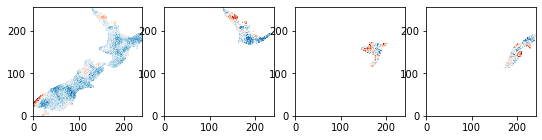

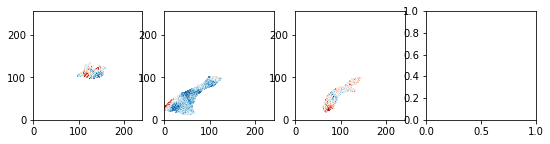

In [30]:
fig, axs = plt.subplots(figsize=(9, 2), ncols=4)
axs[0].pcolormesh(outputs2d[0], cmap='RdBu_r')
axs[1].pcolormesh(outputs2d[0] * ds_regional_masks.NNI.data, cmap='RdBu_r')
axs[2].pcolormesh(outputs2d[0] * ds_regional_masks.WNI.data, cmap='RdBu_r')
axs[3].pcolormesh(outputs2d[0] * ds_regional_masks.ENI.data, cmap='RdBu_r')
plt.show()

fig, axs = plt.subplots(figsize=(9, 2), ncols=4)
axs[0].pcolormesh(outputs2d[0] * ds_regional_masks.NSI.data, cmap='RdBu_r')
axs[1].pcolormesh(outputs2d[0] * ds_regional_masks.WSI.data, cmap='RdBu_r')
axs[2].pcolormesh(outputs2d[0] * ds_regional_masks.ESI.data, cmap='RdBu_r')
plt.show()

### Compute the regionally categorised target

Data used in computing the regional averages:
* `outputs2d`: (anomaly) the regression result converted back to the same shape as VCSN (241x257)
* `climato_tmean`: (raw temperature) climatology of monthly averaged tmean in each 241x257 grid
* `thresholds`: (raw temperature) quantities to divide observations into categories
* `ds_regional_masks`: masks for the six NZ regions

In [31]:
# For train outputs

month = pd.DatetimeIndex([niwa.climate.TIME_FIRST_TRAIN]).month[0]
train_cat3 = {r: [] for r in nz_6_regions}
for i, anomaly in enumerate(outputs2d):
    q = anomaly + climato_tmean.Tmean_average[month].data
    q_mean = {}
    for region in nz_6_regions:
        q_local = q * ds_regional_masks[region].data
        q_mean[region] = np.nanmean(q_local.numpy())
        q33 = thresholds[f'{region}_Q33'].iloc[month]
        q66 = thresholds[f'{region}_Q66'].iloc[month]
        cat = 1 if q_mean[region] < q33 else 2 if q_mean[region] < q66 else 3
        train_cat3[region].append(cat)
    print(f'{niwa.climate.TIME_FIRST_TRAIN + i} (month={month}): {q_mean}')
    
    month = (month + 1) % 12
    

1993-04 (month=4): {'ENI': 11.352588386973395, 'ESI': 8.666645238036288, 'NNI': 13.53524592546691, 'NSI': 9.147887930968425, 'WNI': 11.141859204901271, 'WSI': 7.343736054303839}
1993-05 (month=5): {'ENI': 9.266063393293253, 'ESI': 6.199918461628644, 'NNI': 11.44139322210313, 'NSI': 6.804055333930927, 'WNI': 9.068531988596037, 'WSI': 4.946866154477468}
1993-06 (month=6): {'ENI': 8.23065383611291, 'ESI': 4.82308261817199, 'NNI': 10.315496365633715, 'NSI': 5.50332520400348, 'WNI': 8.026852991094932, 'WSI': 3.5898763220777092}
1993-07 (month=7): {'ENI': 7.913938785101521, 'ESI': 4.666568869793564, 'NNI': 10.004316498336483, 'NSI': 5.225083715855184, 'WNI': 7.795784859111433, 'WSI': 3.4223433049845013}
1993-08 (month=8): {'ENI': 8.228983529777352, 'ESI': 5.433394102516607, 'NNI': 10.210444599203976, 'NSI': 5.668252825555953, 'WNI': 8.04550183708492, 'WSI': 4.072046083110967}
1993-09 (month=9): {'ENI': 8.989113242414469, 'ESI': 6.706078638616116, 'NNI': 10.828945064463399, 'NSI': 6.598577921

In [32]:
df_train_cat3 = pd.DataFrame(train_cat3)
df_train_cat3

ENI  ESI  NNI  NSI  WNI  WSI
0      1    1    1    1    1    1
1      1    1    1    1    1    1
2      2    2    2    2    2    2
3      3    3    3    2    3    2
4      2    2    2    2    2    2
..   ...  ...  ...  ...  ...  ...
255    3    3    3    3    3    3
256    3    3    3    3    3    3
257    2    2    2    2    2    2
258    2    2    2    2    2    2
259    2    2    2    2    2    2

[260 rows x 6 columns]

In [33]:
print(
    (df_train_cat3 == 1).sum(),
    (df_train_cat3 == 2).sum(),
    (df_train_cat3 == 3).sum())

ENI    72
ESI    73
NNI    80
NSI    87
WNI    72
WSI    86
dtype: int64 ENI    94
ESI    94
NNI    82
NSI    89
WNI    93
WSI    85
dtype: int64 ENI    94
ESI    93
NNI    98
NSI    84
WNI    95
WSI    89
dtype: int64


In [34]:
# For train targets

# month = pd.DatetimeIndex([niwa.climate.TIME_FIRST_TRAIN]).month[0]
date = niwa.climate.TIME_FIRST_TRAIN
train_target_cat3 = {r: [] for r in nz_6_regions}
for i, anomaly in enumerate(Climate.vcsn2d(train_targets)):
    month = pd.DatetimeIndex([date]).month[0]
    month_b0 = month - 1
    q = anomaly + climato_tmean.Tmean_average[month_b0].data
    q_mean = {}
    for region in nz_6_regions:
        q_local = q * ds_regional_masks[region].data
        q_mean[region] = np.nanmean(q_local.numpy())
        q33 = thresholds[f'{region}_Q33'].iloc[month_b0]
        q66 = thresholds[f'{region}_Q66'].iloc[month_b0]
        cat = 1 if q_mean[region] < q33 else (2 if q_mean[region] < q66 else 3)
        train_target_cat3[region].append(cat)
    print(f'{niwa.climate.TIME_FIRST_TRAIN + i} (month={month}): {q_mean}')
    
    date += 1
#     month = (month + 1) % 12
    
df_train_target_cat3 = pd.DataFrame(train_target_cat3)
df_train_target_cat3

1993-04 (month=4): {'ENI': 12.998448618800468, 'ESI': 11.035331600206808, 'NNI': 15.281180582338228, 'NSI': 11.07737531059526, 'WNI': 12.966825372747252, 'WSI': 9.733106491225572}
1993-05 (month=5): {'ENI': 11.28857464470626, 'ESI': 8.872524081833006, 'NNI': 13.469674453593836, 'NSI': 9.322146345121606, 'WNI': 11.293954392406357, 'WSI': 7.745148489053242}
1993-06 (month=6): {'ENI': 9.68137747396519, 'ESI': 7.090160050618424, 'NNI': 11.820830735378522, 'NSI': 7.529063641388722, 'WNI': 9.682886460687982, 'WSI': 5.892745623417401}
1993-07 (month=7): {'ENI': 8.255388562979986, 'ESI': 5.727728220068101, 'NNI': 10.334049394965511, 'NSI': 6.150272726634552, 'WNI': 8.339089026531052, 'WSI': 4.483151556414842}
1993-08 (month=8): {'ENI': 7.1863498463798265, 'ESI': 4.855459942115199, 'NNI': 9.350279110972814, 'NSI': 5.039069036127141, 'WNI': 7.309061517216275, 'WSI': 3.4722457029624083}
1993-09 (month=9): {'ENI': 7.003470610048437, 'ESI': 5.113134150336538, 'NNI': 9.086177447151497, 'NSI': 5.0155

ENI  ESI  NNI  NSI  WNI  WSI
0      1    1    1    1    1    1
1      1    1    1    1    1    1
2      1    2    1    2    2    2
3      2    3    2    3    2    3
4      1    3    2    2    2    3
..   ...  ...  ...  ...  ...  ...
255    3    3    3    3    3    3
256    3    3    3    3    3    3
257    2    2    3    2    2    2
258    2    2    3    2    2    2
259    2    2    2    2    2    1

[260 rows x 6 columns]

In [35]:
print(
    (df_train_target_cat3 == 1).sum(),
    (df_train_target_cat3 == 2).sum(),
    (df_train_target_cat3 == 3).sum())

ENI    71
ESI    72
NNI    67
NSI    75
WNI    60
WSI    77
dtype: int64 ENI    91
ESI    89
NNI    70
NSI    82
WNI    82
WSI    86
dtype: int64 ENI     98
ESI     99
NNI    123
NSI    103
WNI    118
WSI     97
dtype: int64


#### Train accuracy

In [36]:
correctness = (df_train_cat3 == df_train_target_cat3)
train_accuracies = {region: correctness[region].astype(int).sum() / correctness[region].count() for region in nz_6_regions}
print(train_accuracies)

{'ENI': 0.7423076923076923, 'ESI': 0.7884615384615384, 'NNI': 0.7615384615384615, 'NSI': 0.7884615384615384, 'WNI': 0.7961538461538461, 'WSI': 0.7692307692307693}


#### Test accuracy

In [37]:
date = niwa.climate.TIME_FIRST_TEST
test_target_cat3 = {r: [] for r in nz_6_regions}
test_cat3 = {r: [] for r in nz_6_regions}
for i, (anomaly, anomaly_target) in enumerate(zip(Climate.vcsn2d(test_outputs), Climate.vcsn2d(test_targets))):
    month = pd.DatetimeIndex([date]).month[0]
    month_b0 = month - 1
    q = anomaly + climato_tmean.Tmean_average[month_b0].data
    q_target = anomaly_target + climato_tmean.Tmean_average[month_b0].data
    q_mean = {}
    q_target_mean = {}
    for region in nz_6_regions:
        q_local = q * ds_regional_masks[region].data
        q_target_local = q_target * ds_regional_masks[region].data
        q_mean[region] = np.nanmean(q_local.numpy())
        q_target_mean[region] = np.nanmean(q_target_local.numpy())
        q33 = thresholds[f'{region}_Q33'].iloc[month_b0]
        q66 = thresholds[f'{region}_Q66'].iloc[month_b0]
        cat = 1 if q_mean[region] < q33 else (2 if q_mean[region] < q66 else 3)
        cat_target = 1 if q_target_mean[region] < q33 else (2 if q_target_mean[region] < q66 else 3)
        test_cat3[region].append(cat)
        test_target_cat3[region].append(cat_target)
    print(f'{niwa.climate.TIME_FIRST_TEST + i} (month={month}) (output): {q_mean}')
    print(f'{niwa.climate.TIME_FIRST_TEST + i} (month={month}) (target): {q_target_mean}')
    
    date += 1
#     month = (month + 1) % 12
    


2015-01 (month=1) (output): {'ENI': 15.259412854196196, 'ESI': 13.297384849336407, 'NNI': 16.74667230016197, 'NSI': 12.90744123043156, 'WNI': 14.772474796085833, 'WSI': 11.58192148645699}
2015-01 (month=1) (target): {'ENI': 15.278337970292844, 'ESI': 13.6257020580785, 'NNI': 16.838548388721655, 'NSI': 12.938987904413715, 'WNI': 15.006174778649486, 'WSI': 11.637287355593562}
2015-02 (month=2) (output): {'ENI': 16.6573215425264, 'ESI': 14.601507164385273, 'NNI': 18.231485171010196, 'NSI': 14.34773345188202, 'WNI': 16.25888964823247, 'WSI': 12.966299328703471}
2015-02 (month=2) (target): {'ENI': 16.463778019065515, 'ESI': 14.911218501635922, 'NNI': 18.31387185719683, 'NSI': 14.382068733806745, 'WNI': 16.374208889270314, 'WSI': 13.254654557404226}
2015-03 (month=3) (output): {'ENI': 16.311344327371238, 'ESI': 14.149355498467237, 'NNI': 18.02453363276511, 'NSI': 14.041659805613605, 'WNI': 15.945840893207366, 'WSI': 12.556919298334245}
2015-03 (month=3) (target): {'ENI': 16.68809413161356, '

In [38]:
df_test_cat3 = pd.DataFrame(test_cat3)
df_test_cat3


ENI  ESI  NNI  NSI  WNI  WSI
0     2    2    3    3    3    2
1     2    3    3    2    3    3
2     3    2    2    2    2    2
3     3    2    3    2    3    2
4     2    2    2    2    2    2
5     2    2    2    2    2    2
6     3    3    3    2    3    3
7     2    2    2    2    2    2
8     2    2    2    2    2    2
9     1    1    1    1    2    1
10    2    2    2    2    2    2
11    2    2    2    2    2    2
12    2    2    2    2    2    2
13    2    2    2    2    2    2
14    3    3    3    3    3    3
15    3    2    3    2    3    2
16    2    2    2    2    2    2
17    3    2    3    3    3    2
18    3    2    3    2    3    3
19    3    3    3    2    3    2
20    3    3    3    2    3    2
21    3    3    3    3    3    3

In [39]:
df_test_target_cat3 = pd.DataFrame(test_target_cat3)
df_test_target_cat3


ENI  ESI  NNI  NSI  WNI  WSI
0     2    3    3    3    3    3
1     2    3    3    2    3    3
2     3    3    3    3    3    3
3     3    3    3    2    3    2
4     3    3    3    3    3    3
5     2    3    3    3    3    2
6     2    3    2    2    2    2
7     2    2    2    2    2    2
8     1    1    1    1    1    1
9     2    2    2    1    2    1
10    2    2    2    1    2    1
11    2    3    3    2    2    2
12    2    2    3    2    3    2
13    3    3    3    3    3    3
14    3    3    3    3    3    3
15    3    3    3    3    3    3
16    3    3    3    3    3    3
17    3    3    3    3    3    3
18    3    3    3    3    3    3
19    3    3    3    2    3    3
20    3    3    3    2    3    3
21    3    2    3    2    3    3

In [40]:
correctness = (df_test_cat3 == df_test_target_cat3)
test_accuracies = {region: correctness[region].astype(int).sum() / correctness[region].count() for region in nz_6_regions}
print(test_accuracies)

{'ENI': 0.7272727272727273, 'ESI': 0.36363636363636365, 'NNI': 0.5454545454545454, 'NSI': 0.5454545454545454, 'WNI': 0.6363636363636364, 'WSI': 0.45454545454545453}
